In [372]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import scipy as sp
from autograd import grad, jacobian
import pennylane as qml

from pennylane import numpy as pnp

# ==============================
# User defined 
# ==============================

In [373]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=2)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0) @ qml.PauliZ(1)])
H_1 = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])

$$
H = -0.5 \cdot Z_0 - 0.5 \cdot Z_1 
$$

$$
= -0.5 \cdot (Z \otimes I) - 0.5 \cdot (I \otimes Z)
$$

$$

$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

In [374]:
# Global Parameters
Tau_global = 0
Gamma_ps_global = 0
Paras_global = pnp.zeros(4)
Phi_global = pnp.array([0], requires_grad = True)

def Dephase_factor(tau):
    """
    Calculates the dephasing factor as a function of the time parameter tau.

    Args:
        tau (float): A time parameter influencing the dephasing.

    Returns:
        float: The calculated dephasing factor.
    """
    return 1 - pnp.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau}
$$

$$
\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [375]:
@qml.qnode(dev)
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    phi_z = Paras_global[1]
    tau_1 = Paras_global[2]
    tau_2 = Paras_global[3]
    
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(H, tau_1, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1)    
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(H, tau_2, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    
    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(H_1, phi, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 

    qml.RZ(phi_z, wires=0)
    qml.RZ(phi_z, wires=1)
    
    qml.RX(np.pi/(2), wires=0)
    qml.RX(np.pi/(2), wires=1)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1])

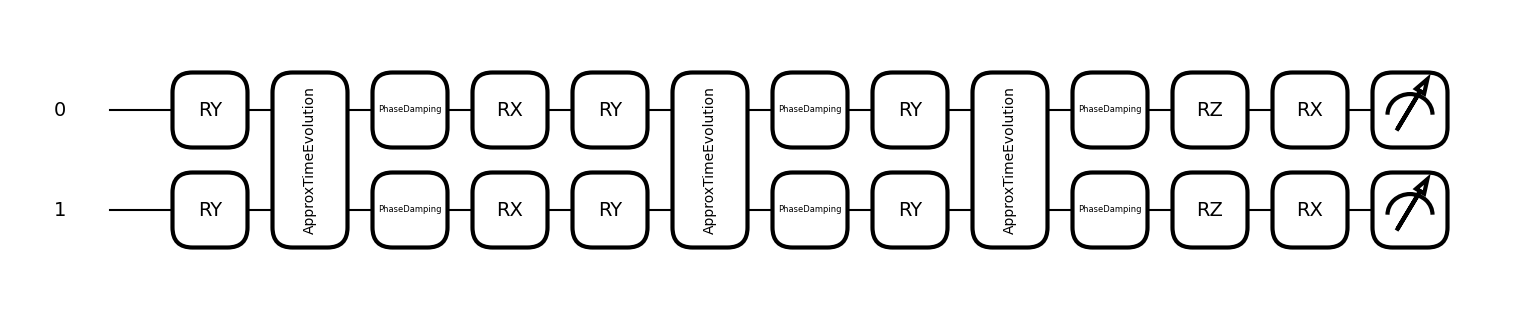

In [376]:
fig, ax = qml.draw_mpl(circuit)(np.pi)

In [377]:
@qml.qnode(dev)
def Post_selection(phi):

    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = pnp.tensor([
        [pnp.sqrt(1 - Gamma_ps_global), 0], 
        [0, 1]
    ], dtype=pnp.complex128)
    
    Numerator = pnp.kron(K, K) @ get_density_matrix @ pnp.kron(K, K).conj().T
    Denominator = pnp.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
    return qml.density_matrix(wires = [0, 1])  

$$ 
K =  \begin{bmatrix}
\sqrt{1-\gamma_{ps}} & 0 \\
0 & 1 
\end{bmatrix}  
$$


$$
\rho_{ps} = 
\frac{(K \otimes K) \rho (K \otimes K)^{\dagger}}
% (K^{\dagger} \otimes I ^{\dagger})}

{Tr[(K \otimes K) \rho (K \otimes K)^{\dagger}]}
$$

In [378]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Sets global parameters for dephasing time and gamma post-selection.

    Args:
        desired_tau_dephase (float): The desired dephasing time.
        desired_gamma_post_selection (float): The gamma value for post-selection.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = desired_tau_dephase
    Gamma_ps_global = desired_gamma_post_selection

In [379]:
def cost_function(paras):
    """
    Defines the cost function for optimization, which is the negative of the 
    Classical Fisher Information (CFI).

    Args:
        paras (array): Parameters to optimize.

    Returns:
        float: The negative value of the CFI for the given parameters.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

In [380]:
def get_constraints(gamma_ps_current, phi_current, tau_current):
    N =2*np.pi * int(phi_current / (2*np.pi))
    if gamma_ps_current == 8e-1:
        if tau_current == 5e-3:
            default_1 = [
                (2.35619449, 2.35619449), 
                (0.25941505, 2.86058495), 
                (np.pi/2, np.pi/2),
                (np.pi/2, np.pi/2)
            ]
            if phi_current <= 0.21 + N:
                 return [
                (2.35619449, 2.35619449), 
                (0.25941505, 2.86058495), 
                (np.pi/2, np.pi/2),
                (np.pi/2, np.pi/2)
            ]
            elif phi_current <= 0.71 + N:
                return [
                (2.35619449, 2.35619449), 
                (0.459415051, 0.959415051), 
                (np.pi/2, np.pi/2),
                (np.pi/2, np.pi/2)
            ]
            elif phi_current <= 0.81 + N:
                return default_1
            elif phi_current <= 1.01 + N:
                return[
                (2.35619449, 2.35619449), 
                (1.059415051, 1.259415051), 
                (np.pi/2, np.pi/2),
                (np.pi/2, np.pi/2)
            ]
            elif phi_current <= 2.41 + N:
                return default_1
            elif phi_current <= 2.91 + N:
                return[
                (2.35619449, 2.35619449), 
                (2.160584949, 2.660584949), 
                (np.pi/2, np.pi/2),
                (np.pi/2, np.pi/2)
            ]
            elif phi_current <= 3.41 + N:
                return default_1
            elif phi_current <= 3.81 + N:
                return[
                (2.35619449, 2.35619449), 
                (0.517822398, 0.917822398), 
                (np.pi/2, np.pi/2),
                (np.pi/2, np.pi/2)
            ]
            elif phi_current <= 5.51 + N:
                return default_1
            elif phi_current <= 6.01 + N:
                return[
                (2.35619449, 2.35619449), 
                (2.118992295, 2.618992295), 
                (np.pi/2, np.pi/2),
                (np.pi/2, np.pi/2)
            ]
            else:
                return default_1
                
                
                
            

In [381]:
# ===================
tau_set = np.array([5e-3])
gamma_ps_set = 0.8
set_circuit(tau_set, gamma_ps_set)
initial_parameters = np.zeros(4)
initial_parameters[:4] = np.pi/2
# initial_parameters[2] = 0.5
# ===================

sweep_range = np.array([1e-2, np.pi*2, 1e-2])
Phi = np.arange(sweep_range[0], sweep_range[1], sweep_range[2])
Data = np.zeros((len(Phi), 4 + 2))
Data[:,0] = Phi
gradient = grad(cost_function)
hessian = jacobian(gradient)

for tau_idx, tau_current in enumerate(tau_set):
    set_circuit(tau_current, gamma_ps_set)
    for phi_idx, phi_current in enumerate(Phi):
        Phi_global = pnp.array([phi_current], requires_grad = True)

        opt_result = sp.optimize.minimize(
            fun = cost_function, 
            x0 = initial_parameters, 
            method = 'L-BFGS-B', 
            # bounds = [
            #     (2.35619449, 2.35619449), 
            #     (0.25941505, 2.86058495), 

            #     (np.pi/2, np.pi/2),
            #     (np.pi/2, np.pi/2)
            # ], 
            bounds = get_constraints(gamma_ps_set, phi_current, tau_current),
            jac = gradient,
            # hess = hessian,
            tol = 1e-12,
            options={
                'ftol': 1e-12, 
                'gtol': 1e-12
            }
        )
        
        # minimizer_kwargs = {"method": "L-BFGS-B"}
        # opt_result = sp.optimize.basinhopping(
        #     cost_function, 
        #     initial_parameters, 
        #     minimizer_kwargs=minimizer_kwargs, 
        #     niter = 5
        # )

        print("CFI =", -opt_result.fun, "Paras =", opt_result.x)
        Data[phi_idx][1] = -opt_result.fun
        Data[phi_idx][2:] = opt_result.x

CFI = 6.854624531282384 Paras = [2.35619449 0.25941505 1.57079633 1.57079633]
CFI = 6.854624531282408 Paras = [2.35619449 0.26941505 1.57079633 1.57079633]
CFI = 6.854624531282396 Paras = [2.35619449 0.27941505 1.57079633 1.57079633]
CFI = 6.85462453128237 Paras = [2.35619449 0.28941505 1.57079633 1.57079633]
CFI = 6.854624531282384 Paras = [2.35619449 0.29941505 1.57079633 1.57079633]
CFI = 6.854624531282405 Paras = [2.35619449 0.30941505 1.57079633 1.57079633]
CFI = 6.854624531282388 Paras = [2.35619449 0.31941505 1.57079633 1.57079633]
CFI = 6.854624531282388 Paras = [2.35619449 0.32941505 1.57079633 1.57079633]
CFI = 6.854624531282373 Paras = [2.35619449 0.33941505 1.57079633 1.57079633]
CFI = 6.854624531282369 Paras = [2.35619449 0.34941505 1.57079633 1.57079633]
CFI = 6.854624531282396 Paras = [2.35619449 0.35941505 1.57079633 1.57079633]
CFI = 6.854624531282371 Paras = [2.35619449 0.36941505 1.57079633 1.57079633]
CFI = 6.854624531282378 Paras = [2.35619449 0.37941505 1.57079633

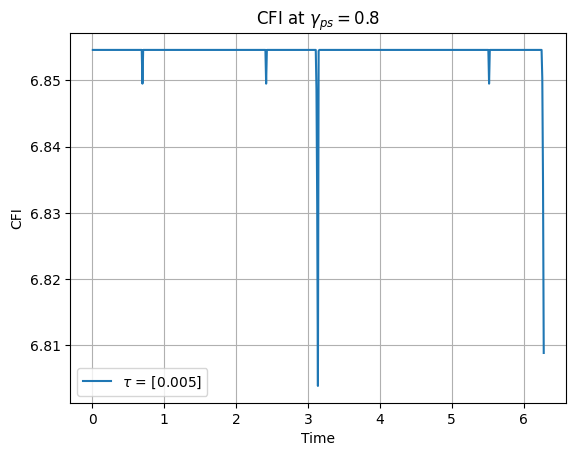

In [382]:
plt.plot(Data[:,0], Data[:,1], label = f'$\\tau$ = {tau_set}')
plt.title(f'CFI at $\gamma_{{ps}} = {gamma_ps_set}$')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()
plt.show()

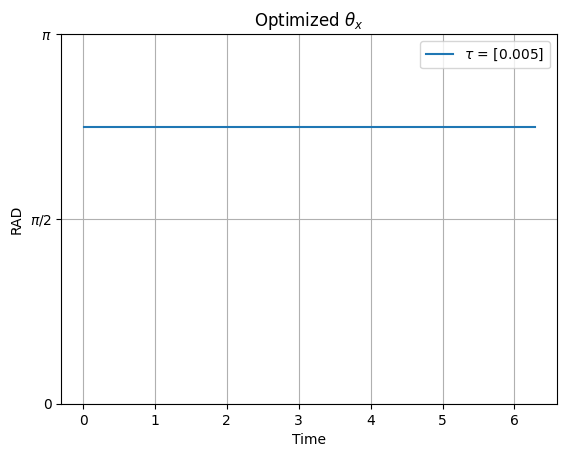

In [383]:
plt.plot(Data[:,0], Data[:,2], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, np.pi)
plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [384]:
Data[:,2]

array([2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
       2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619

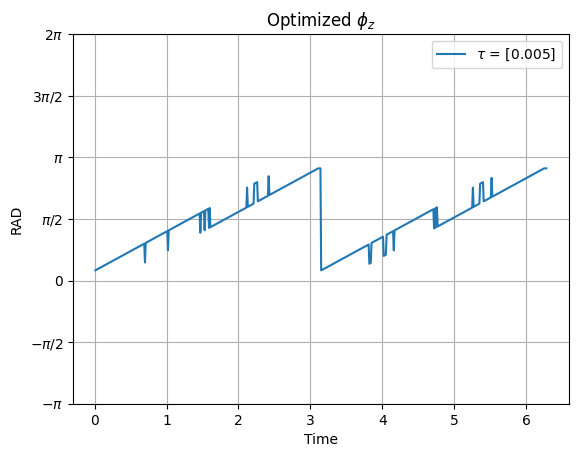

In [385]:
plt.plot(Data[:,0], Data[:,3], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
# plt.ylim(-np.pi/2, 3*np.pi/2)
plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [386]:
for idx, phi_current in enumerate(Data[:,0]):
    print('PHI:', f"{phi_current:.2f}", 'PHI_Z:', f"{Data[idx,3]:.9f}")
# print(Data[:,0], Data[:,3])

PHI: 0.01 PHI_Z: 0.259415051
PHI: 0.02 PHI_Z: 0.269415051
PHI: 0.03 PHI_Z: 0.279415051
PHI: 0.04 PHI_Z: 0.289415051
PHI: 0.05 PHI_Z: 0.299415051
PHI: 0.06 PHI_Z: 0.309415051
PHI: 0.07 PHI_Z: 0.319415051
PHI: 0.08 PHI_Z: 0.329415051
PHI: 0.09 PHI_Z: 0.339415051
PHI: 0.10 PHI_Z: 0.349415051
PHI: 0.11 PHI_Z: 0.359415051
PHI: 0.12 PHI_Z: 0.369415051
PHI: 0.13 PHI_Z: 0.379415051
PHI: 0.14 PHI_Z: 0.389415042
PHI: 0.15 PHI_Z: 0.399415051
PHI: 0.16 PHI_Z: 0.409415051
PHI: 0.17 PHI_Z: 0.419415051
PHI: 0.18 PHI_Z: 0.429415051
PHI: 0.19 PHI_Z: 0.439415051
PHI: 0.20 PHI_Z: 0.449415052
PHI: 0.21 PHI_Z: 0.459415051
PHI: 0.22 PHI_Z: 0.469415051
PHI: 0.23 PHI_Z: 0.479415056
PHI: 0.24 PHI_Z: 0.489415051
PHI: 0.25 PHI_Z: 0.499415051
PHI: 0.26 PHI_Z: 0.509415051
PHI: 0.27 PHI_Z: 0.519415052
PHI: 0.28 PHI_Z: 0.529415051
PHI: 0.29 PHI_Z: 0.539415051
PHI: 0.30 PHI_Z: 0.549415051
PHI: 0.31 PHI_Z: 0.559415057
PHI: 0.32 PHI_Z: 0.569415051
PHI: 0.33 PHI_Z: 0.579415051
PHI: 0.34 PHI_Z: 0.589415052
PHI: 0.35 PHI_

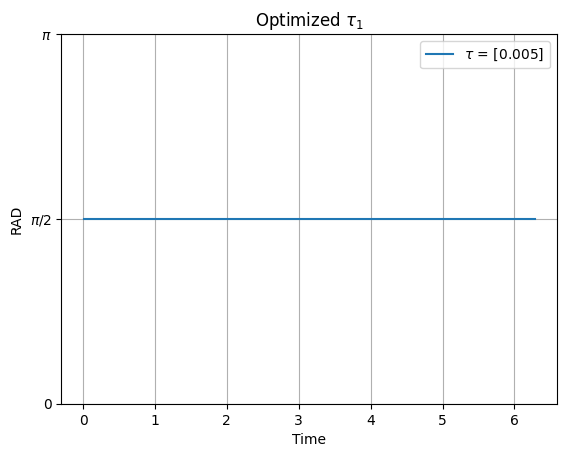

In [387]:
plt.plot(Data[:,0], Data[:,4], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, np.pi)
plt.title(f'Optimized $\\tau_{1}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

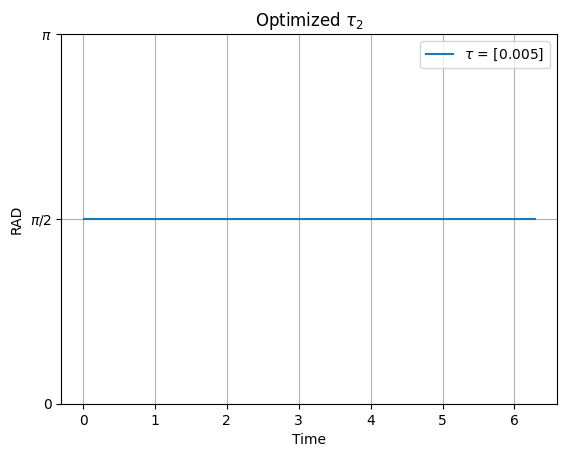

In [388]:
plt.plot(Data[:,0], Data[:,5], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, np.pi)
plt.title(f'Optimized $\\tau_{2}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()